<a href="https://colab.research.google.com/github/raihanewubd/CSE457/blob/main/Lab1_Decision_Tree_and_Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Lab 1 - Decision Tree

In [ ]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import tree
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from graphviz import Digraph

# Load iris data set

In [ ]:
from sklearn.datasets import load_iris
iris = load_iris()
# Convert the data to a pandas dataframe
df = pd.DataFrame(iris.data, columns=iris.feature_names)
# Add the target column
df['species'] = iris.target
# Check the shape and summary of the data
print(df.head())

In [ ]:
print(df.shape)
print(df.describe())

Analyze the dataset

In [ ]:
# Plot the pairwise scatter plot of the features
pd.plotting.scatter_matrix(df, figsize=(12, 8), diagonal='kde')
plt.show()

# Decision tree using Numpy

In [59]:
X = iris.data
y = iris.target
# Split the data into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [60]:
class DecisionTree:
    def __init__(self, max_depth=None, feature_names=None):
        self.max_depth = max_depth
        self.tree = None
        self.feature_names = feature_names

    def entropy(self, y):
        """
        Calculates the entropy of a dataset.

        Args:
          y: 1d array of labels

        Returns:
          float: entropy
        """
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        return -np.sum(probabilities * np.log2(probabilities))

    def information_gain(self, y, y1, y2):
        """
        Calculates the information gain of a split.

        Args:
          y: 1d array of labels before split
          y1: 1d array of labels in the left split
          y2: 1d array of labels in the right split

        Returns:
          float: information gain
        """
        p = len(y1) / len(y)
        return self.entropy(y) - p * self.entropy(y1) - (1 - p) * self.entropy(y2)

    def best_split(self, X, y):
        """
        Finds the best split for a dataset.

        Args:
          X: 2d array of features
          y: 1d array of labels

        Returns:
          tuple: (best_feature_index, best_threshold)
        """
        best_gain = 0
        best_feature_index = None
        best_threshold = None
        for feature_index in range(X.shape[1]):
            #print(f"feature_index: {feature_index}")
            thresholds = np.unique(X[:, feature_index])
            #print(f"thresholds: {thresholds}")
            for threshold in thresholds:
                #print(f"threshold: {threshold}")
                y1 = y[X[:, feature_index] <= threshold]
                y2 = y[X[:, feature_index] > threshold]
                #print(f"y1: {y1}")
                #print(f"y2: {y2}")
                gain = self.information_gain(y, y1, y2)
                #print(f"gain: {gain}")
                if gain > best_gain:
                    best_gain = gain
                    best_feature_index = feature_index
                    best_threshold = threshold
        return best_feature_index, best_threshold

    def build_tree(self, X, y, depth=0):
        """
        Builds a decision tree recursively.

        Args:
          X: 2d array of features
          y: 1d array of labels
          depth: current depth of the tree

        Returns:
          dict: decision tree
        """
        if len(np.unique(y)) == 1:
            return y[0]
        if self.max_depth is not None and depth >= self.max_depth:
            return np.argmax(np.bincount(y))
        #print(f"best split of {X} and {y}")
        feature_index, threshold = self.best_split(X, y)
        left_indices = X[:, feature_index] <= threshold
        right_indices = X[:, feature_index] > threshold
        left_tree = self.build_tree(X[left_indices], y[left_indices], depth + 1)
        right_tree = self.build_tree(X[right_indices], y[right_indices], depth + 1)

        # Include feature name in the tree
        feature_name = self.feature_names[feature_index] if self.feature_names else feature_index
        return {
            'feature_name': feature_name,
            'feature_index': feature_index,
            'threshold': threshold,
            'left': left_tree,
            'right': right_tree,
        }

    def fit(self, X, y):
        """
        Fits the decision tree to the training data.

        Args:
          X: 2d array of features
          y: 1d array of labels
        """
        self.tree = self.build_tree(X, y)

    def predict(self, X):
        """
        Predicts the labels for a dataset.

        Args:
          X: 2d array of features

        Returns:
          1d array: predicted labels
        """
        if len(X.shape) == 1:  # Handle single sample input
            X = X.reshape(1, -1)
        return np.array([self._predict(self.tree, x) for x in X])

    def _predict(self, tree, x):
        """
        Predicts the label for a single data point.

        Args:
          tree: decision tree
          x: 1d array of features

        Returns:
          int: predicted label
        """
        if isinstance(tree, dict):
            if x[tree['feature_index']] <= tree['threshold']:
                return self._predict(tree['left'], x)
            else:
                return self._predict(tree['right'], x)
        else:
            return tree

    def visualize_tree(self, tree=None, dot=None, parent=None, edge_label=None):
        """
        Visualizes the decision tree using graphviz.

        Args:
            tree: decision tree (root node)
            dot: graphviz Digraph object
            parent: parent node
            edge_label: label for the edge connecting parent to current node
        """
        if dot is None:
            dot = Digraph()
            dot.node(name='root', label=str(tree['feature_name']) + ' <= ' + str(round(tree['threshold'], 2)))
            self.visualize_tree(tree['left'], dot, 'root', 'True')
            self.visualize_tree(tree['right'], dot, 'root', 'False')
            return dot

        if isinstance(tree, dict):
            node_id = str(id(tree))
            node_label = str(tree['feature_name']) + ' <= ' + str(round(tree['threshold'], 2))
            dot.node(name=node_id, label=node_label)
            if parent is not None:
                dot.edge(parent, node_id, label=edge_label)
            self.visualize_tree(tree['left'], dot, node_id, 'True')
            self.visualize_tree(tree['right'], dot, node_id, 'False')
        else:
            node_id = str(id(tree))
            dot.node(name=node_id, label=str(tree), shape='box')  # Leaf nodes as boxes
            if parent is not None:
                dot.edge(parent, node_id, label=edge_label)


# Load the iris dataset
iris = load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names  # Get feature names

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(feature_names)
# Create and train the decision tree using the training data
tree = DecisionTree(max_depth=6, feature_names=feature_names)  # Pass feature names
tree.fit(X_train, y_train)

# Visualize the tree
dot = tree.visualize_tree(tree.tree)
dot.render('decision_tree', format='png')  # Save and display the tree
from IPython.display import Image
Image('decision_tree.png')
# Predict the labels for the test data
y_pred = tree.predict(X_test)

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000


# Decision Tree using Sklearn

Split the dataset into train and test. Fix the error in below code

In [61]:
from sklearn.model_selection import train_test_split
# Define the features and the target
X = df.drop('species', axis=1)
y = df['species']
# Split the data into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Train and test

In [62]:
# Create a decision tree classifier with gini criterion and maximum depth of 3
dt = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=42)
# Fit the model on the train data
dt.fit(X_train, y_train)
# Make predictions on the test data
y_pred = dt.predict(X_test)

Show the results

Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1-score: 1.00


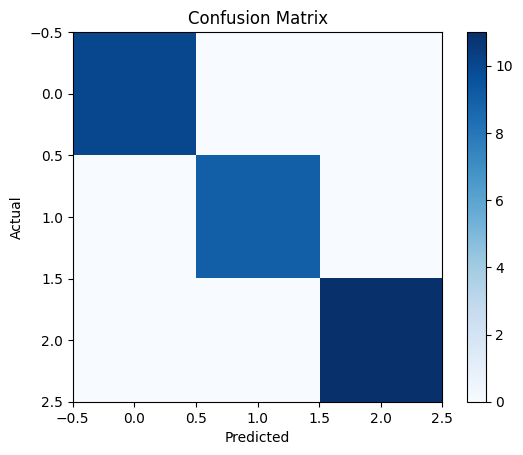

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



In [63]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
# Calculate the accuracy, precision, recall, and f1-score
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='macro')
rec = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
# Print the results
print(f"Accuracy: {acc:.2f}")
print(f"Precision: {prec:.2f}")
print(f"Recall: {rec:.2f}")
print(f"F1-score: {f1:.2f}")
# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.colorbar()
plt.show()
# Print the classification report
print(classification_report(y_test, y_pred))

Plot the tree

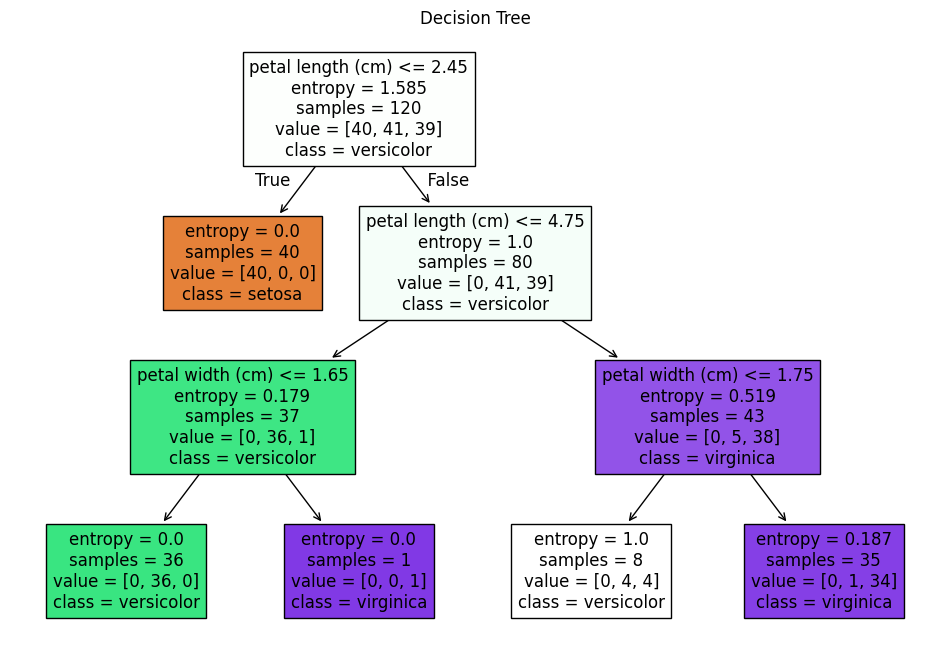

In [64]:
# Plot the decision tree
plt.figure(figsize=(12, 8))
plot_tree(dt, feature_names=iris.feature_names, class_names=iris.target_names, filled=True)
plt.title('Decision Tree')
plt.show()

# Random Forest

In [65]:
# Load the breast cancer dataset
data = load_breast_cancer()
X, y = data.data, data.target

In [66]:
# Convert the data to a Pandas DataFrame
df = pd.DataFrame(data.data, columns=data.feature_names)
print(df.head())
# Describe the dataset
#description = df.describe()
#print(description)
# Plot the pairwise scatter plot of the features
#pd.plotting.scatter_matrix(df, figsize=(12, 8), diagonal='kde')
#plt.show()

   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  ...  worst radius  worst texture  worst perimeter  \
0           

In [67]:
df['target'] = data.target
X = df.loc[:, df.columns != 'target']
y = df.loc[:, 'target'].values

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Create a random forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

In [ ]:
# Train the model
rf_classifier.fit(X_train, y_train)

In [ ]:
# Make predictions
y_pred = rf_classifier.predict(X_test)

In [ ]:
# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

In [ ]:
plt.figure(figsize=(20, 20))
_ = tree.plot_tree(rf_classifier.estimators_[0], feature_names=X.columns, filled=True)
plt.show()

Classify Mushroom Using Decision Tree and Random Forest.

Dataset: https://archive.ics.uci.edu/dataset/73/mushroom

Task details:

2.   Perform Exploratory Data Analysis (EDA) on the dataset.
3.   Evaluate and compare Random Forest tree accuracy for the following n_estimators values 1,50,100,150,200, and 250.
4.   Evaluate and compare performance of Random Forest and Decision Tree.


